In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import scipy.stats as st
import numpy as np
from pathlib import Path
%matplotlib inline


In [13]:
# Define function to filter and group data
def filter_and_group_data(vehicle_df, person_df):
    cleaned_df = vehicle_df[['STATE','STATENAME','MONTHNAME','MONTH','BODY_TYP','DEATHS','ACC_TYPE','OWNER','MAK_MODNAME','HARM_EVNAME', 'MAN_COLLNAME',
                               'VNUM_LAN','INJ_SEV','INJ_SEVNAME']]

    new_names = {"HARM_EVNAME": "Accident Type", "MAN_COLLNAME": "Vehicle Crash Description", "VNUM_LAN": "Lanes Involved",
                 "BODY_TYP": "Vehicle Type ID", "STATENAME": "State Name", "MONTHNAME": "Month Name", "MONTH": "Month", "BODY_TYPNAME": "Body Type",
                 "DEATHS":"Deaths", "OWNER": "Owner", "MAK_MODNAME": "Make and Model","INJ_SEV": "Injury ID","INJ_SEVNAME":"Injury Type"}

    fixed_df = cleaned_df.rename(columns=new_names)

    filtered_df = fixed_df[(fixed_df['Vehicle Type ID'].between(80, 87)) & (fixed_df['Lanes Involved'] != 1)]

    grouped_df = filtered_df.groupby('State Name')['Injury Type'].value_counts().reset_index(name='Count')

    total_count_by_state_df = grouped_df.groupby('State Name')['Count'].sum().reset_index(name='Total Count')

    merged_df = grouped_df.merge(total_count_by_state_df, on='State Name')

    return merged_df

In [14]:
# Define function to categorize states
def categorize_states(injuries_count_df):
    legal_df = injuries_count_df[injuries_count_df['State Name'] == "California"]
    somewhat_legal_df = injuries_count_df[injuries_count_df['State Name'].isin(["Utah", "Hawaii"])]
    illegal_df = injuries_count_df[~injuries_count_df['State Name'].isin(["Montana", "New Mexico", "Texas", "Oklahoma",
                                                                          "Missouri", "Arkansas", "Ohio", "Kentucky",
                                                                          "North Carolina", "West Virgina", "Delaware", "Mississippi"])]
    not_mentioned_df = injuries_count_df[~injuries_count_df['State Name'].isin(["Montana", "New Mexico", "Texas", "Oklahoma",
                                                                                "Missouri", "Arkansas", "Ohio", "Kentucky",
                                                                                "North Carolina", "West Virgina", "Delaware", "Mississippi",
                                                                                "California", "Utah", "Hawaii", "Total"])]

    return legal_df, somewhat_legal_df, illegal_df, not_mentioned_df

In [15]:
# Read vehicle data
csv_path2019 = Path("Resources/vehicle_2019.csv")
csv_path2020 = Path("Resources/vehicle_2020.csv")
csv_path2021 = Path("Resources/vehicle_2021.csv")

vehicle2019_df = pd.read_csv(csv_path2019, encoding='cp1252', low_memory=False)
vehicle2020_df = pd.read_csv(csv_path2020, encoding='cp1252', low_memory=False)
vehicle2021_df = pd.read_csv(csv_path2021, encoding='cp1252', low_memory=False)

# Read person data
csv2_path2019 = Path("Resources/Person_2019.csv")
csv2_path2020 = Path("Resources/Person_2020.csv")
csv2_path2021 = Path("Resources/Person_2021.csv")

person2019_df = pd.read_csv(csv2_path2019, encoding='cp1252', low_memory=False)
person2020_df = pd.read_csv(csv2_path2020, encoding='cp1252', low_memory=False)
person2021_df = pd.read_csv(csv2_path2021, encoding='cp1252', low_memory=False)

# Extract injury columns from person data and add them to vehicle data
injuries2019_df = person2019_df[['INJ_SEV', 'INJ_SEVNAME']]
injuries2020_df = person2020_df[['INJ_SEV', 'INJ_SEVNAME']]
injuries2021_df = person2021_df[['INJ_SEV', 'INJ_SEVNAME']]

vehicle2019_df[['INJ_SEV', 'INJ_SEVNAME']] = injuries2019_df
vehicle2020_df[['INJ_SEV', 'INJ_SEVNAME']] = injuries2020_df
vehicle2021_df[['INJ_SEV', 'INJ_SEVNAME']] = injuries2021_df

# Filter and group data for each year
merged2019_df = filter_and_group_data(vehicle2019_df, person2019_df)
merged2020_df = filter_and_group_data(vehicle2020_df, person2020_df)
merged2021_df = filter_and_group_data(vehicle2021_df, person2021_df)

# Categorize states for each year
legal_2019_df, somewhat_legal_2019_df, illegal_2019_df, not_mentioned_2019_df = categorize_states(merged2019_df)
legal_2020_df, somewhat_legal_2020_df, illegal_2020_df, not_mentioned_2020_df = categorize_states(merged2020_df)
legal_2021_df, somewhat_legal_2021_df, illegal_2021_df, not_mentioned_2021_df = categorize_states(merged2021_df)

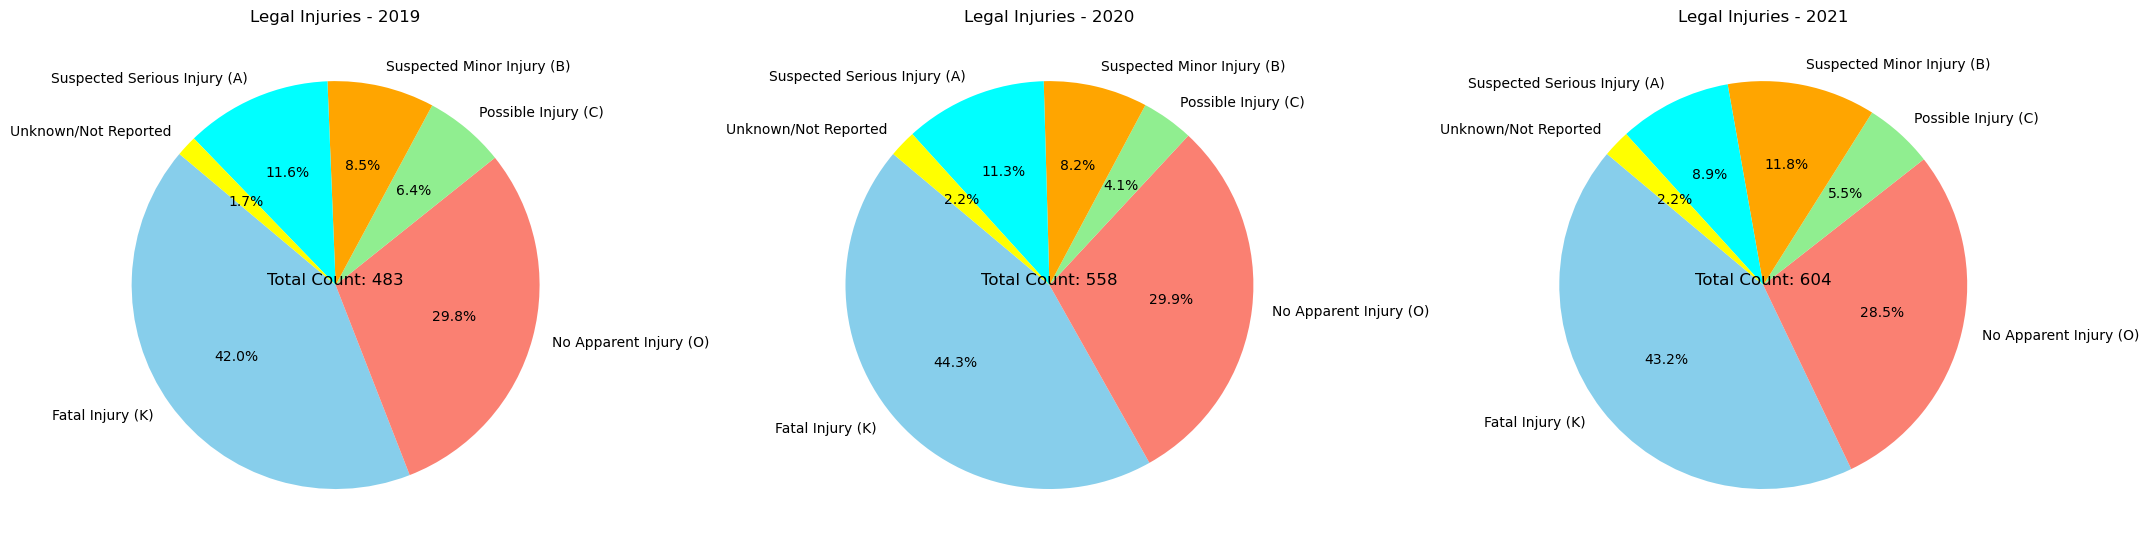

In [24]:
# Visualize data
plt.figure(figsize=(25, 8))

# Legal Pie Charts
years = [2019, 2020, 2021]
for i, legal_df in enumerate([legal_2019_df, legal_2020_df, legal_2021_df]):
    plt.subplot(1, 3, i+1)  # Adjust subplot indexing
    legal_injury_chart = legal_df.groupby("Injury Type")["Count"].sum()
    wedges, _, autotexts = plt.pie(legal_injury_chart, labels=legal_injury_chart.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
    total_count = legal_injury_chart.sum()
    plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
    plt.title(f'Legal Injuries - {years[i]}')  # Use years list

    plt.subplots_adjust(wspace=0.4)  # Add space between subplots

    plt.show 


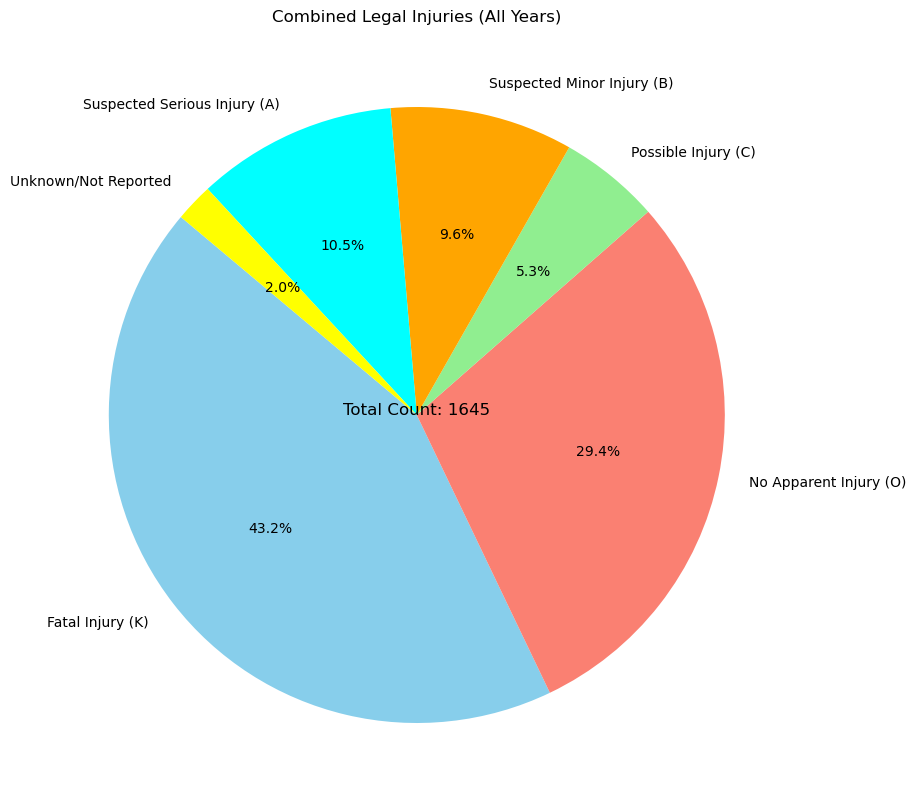

In [28]:
# Concatenate the DataFrames for all years
legal_combined_df = pd.concat([legal_2019_df, legal_2020_df, legal_2021_df], ignore_index=True)

# Calculate the total counts for each injury type
legal_injury_chart_combined = legal_combined_df.groupby("Injury Type")["Count"].sum()

# Create the pie chart
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
wedges, _, autotexts = plt.pie(legal_injury_chart_combined, labels=legal_injury_chart_combined.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
total_count_combined = legal_injury_chart_combined.sum()
plt.text(0, 0, f'Total Count: {total_count_combined}', color='black', fontsize=12, ha='center')
plt.title('Combined Legal Injuries (All Years)')  # Set the title of the pie chart

plt.show()

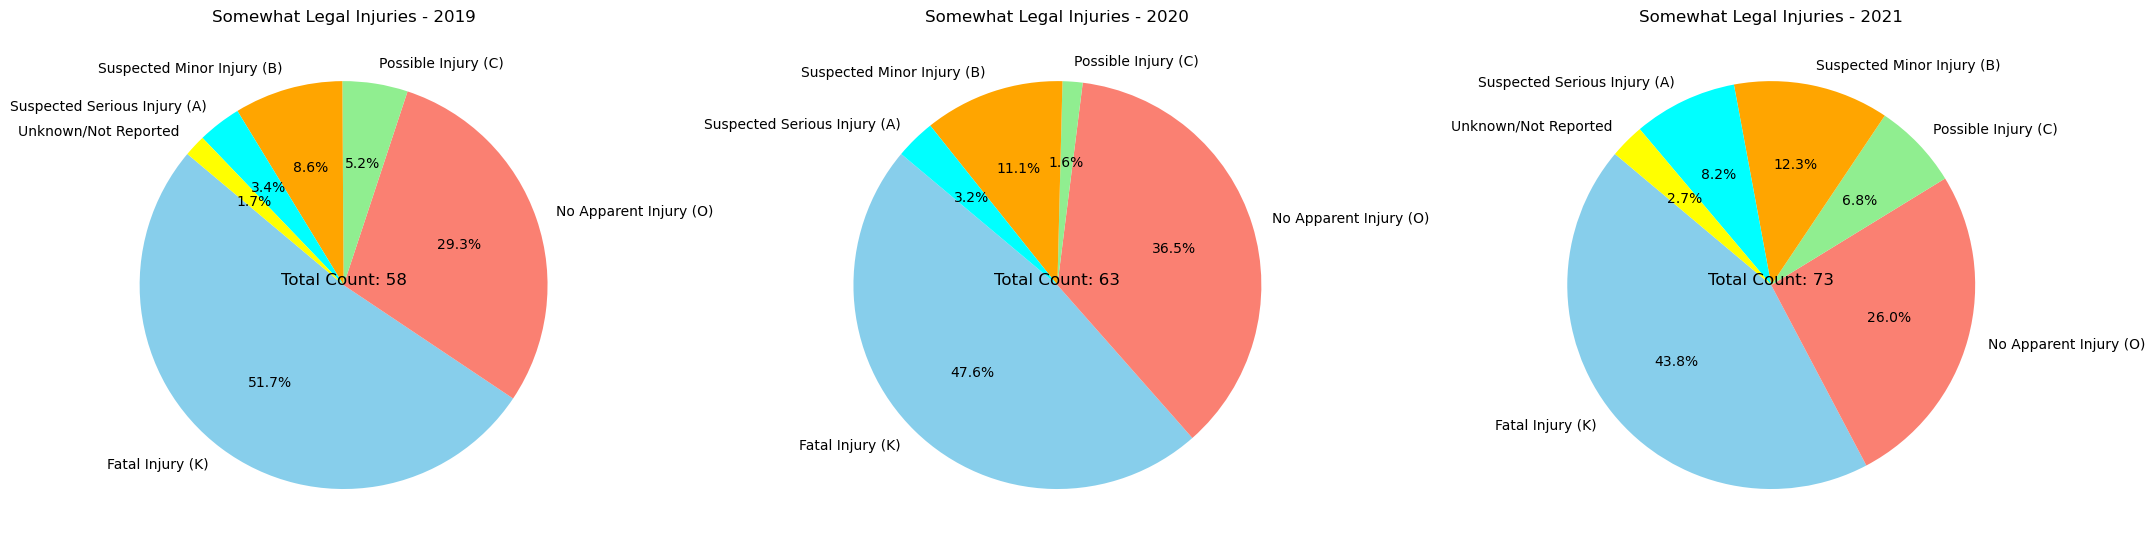

In [23]:
# Visualize data
plt.figure(figsize=(25, 8))

# Legal Pie Charts
years = [2019, 2020, 2021]
for i, somewhat_legal_df in enumerate([somewhat_legal_2019_df, somewhat_legal_2020_df, somewhat_legal_2021_df]):
    plt.subplot(1, 3, i+1)  # Adjust subplot indexing
    somewhat_legal_injury_chart = somewhat_legal_df.groupby("Injury Type")["Count"].sum()
    wedges, _, autotexts = plt.pie(somewhat_legal_injury_chart, labels=somewhat_legal_injury_chart.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
    total_count = somewhat_legal_injury_chart.sum()
    plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
    plt.title(f'Somewhat Legal Injuries - {years[i]}')  # Use years list

    plt.subplots_adjust(wspace=0.4)  # Add space between subplots

    plt.show 

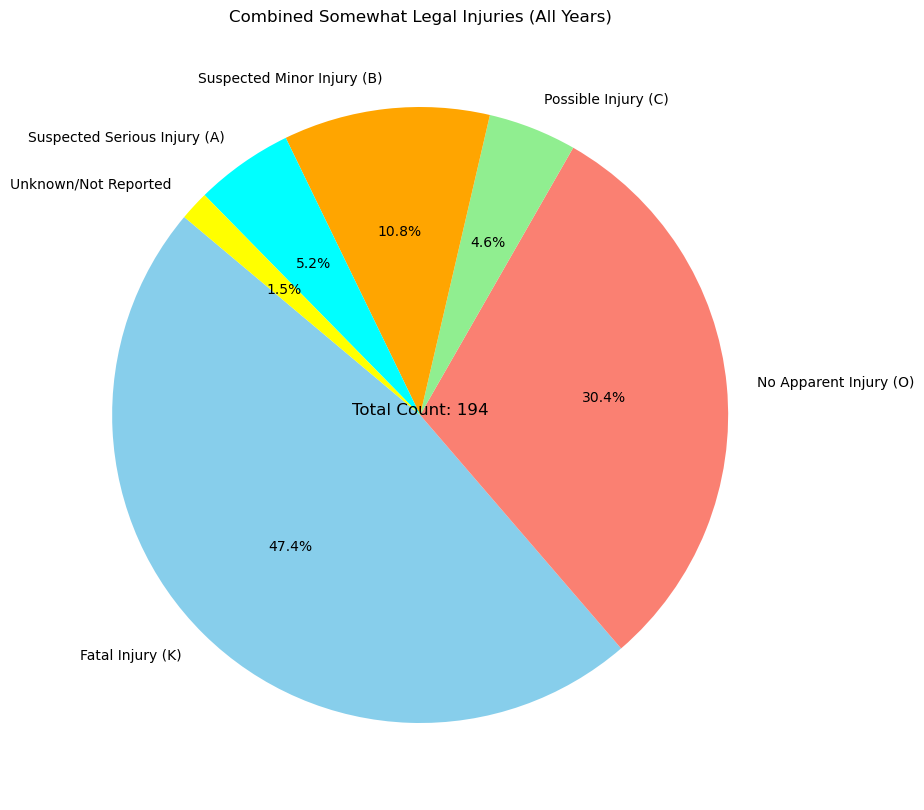

In [30]:
# Concatenate the DataFrames for all years
somewhat_legal_combined_df = pd.concat([somewhat_legal_2019_df, somewhat_legal_2020_df, somewhat_legal_2021_df], ignore_index=True)

# Calculate the total counts for each injury type
somewhat_legal_injury_chart_combined = somewhat_legal_combined_df.groupby("Injury Type")["Count"].sum()

# Create the pie chart
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
wedges, _, autotexts = plt.pie(somewhat_legal_injury_chart_combined, labels=somewhat_legal_injury_chart_combined.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
total_count_combined = somewhat_legal_injury_chart_combined.sum()
plt.text(0, 0, f'Total Count: {total_count_combined}', color='black', fontsize=12, ha='center')
plt.title('Combined Somewhat Legal Injuries (All Years)')  # Set the title of the pie chart

plt.show()

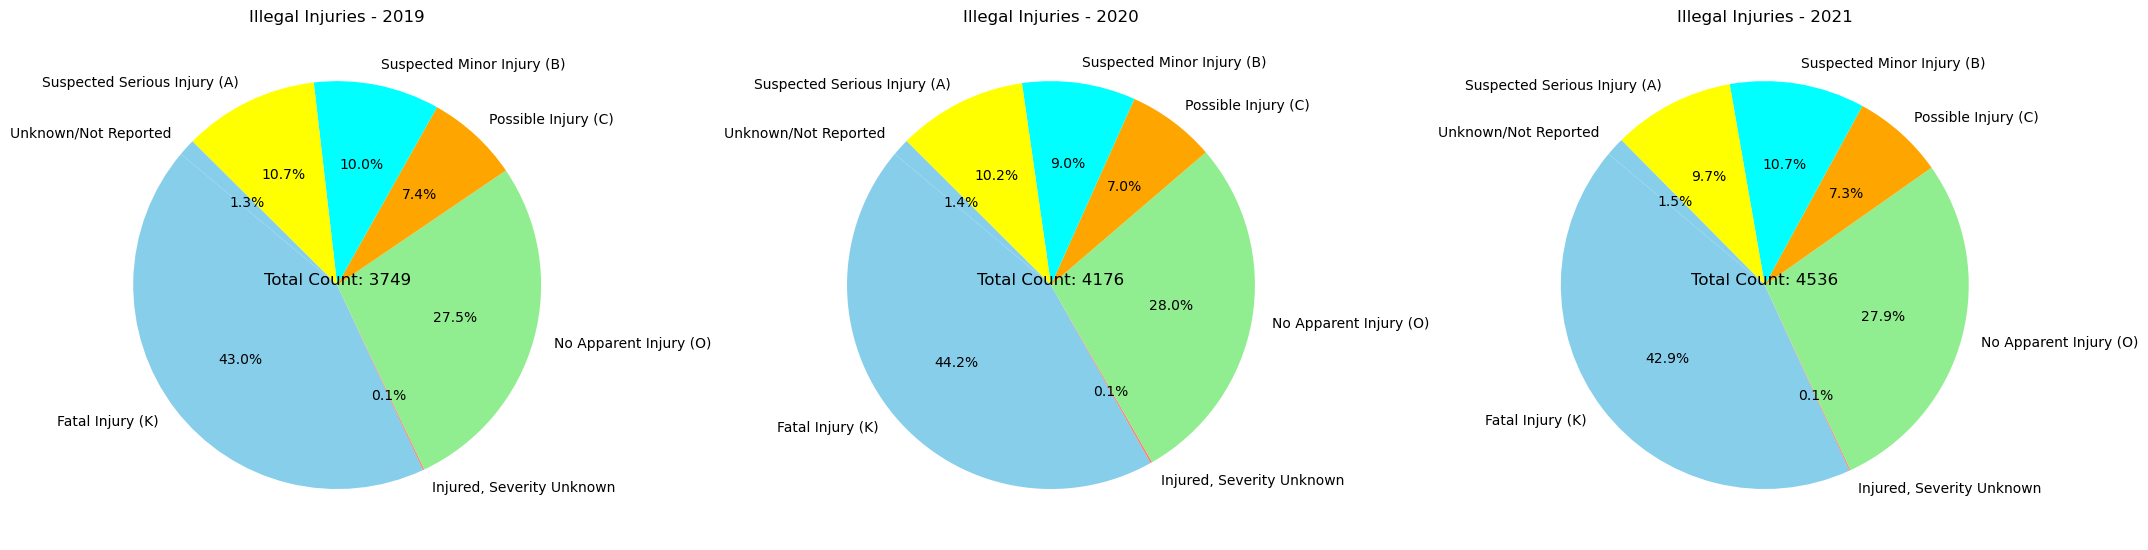

In [22]:
# Visualize data
plt.figure(figsize=(25, 8))

# Illegal Pie Charts
years = [2019, 2020, 2021]
for i, illegal_df in enumerate([illegal_2019_df, illegal_2020_df, illegal_2021_df]):
    plt.subplot(1, 3, i+1)  # Adjust subplot indexing
    illegal_injury_chart = illegal_df.groupby("Injury Type")["Count"].sum()
    wedges, _, autotexts = plt.pie(illegal_injury_chart, labels=illegal_injury_chart.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
    total_count = illegal_injury_chart.sum()
    plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
    plt.title(f'Illegal Injuries - {years[i]}')  # Use years list

    plt.subplots_adjust(wspace=0.4)  # Add space between subplots

plt.show()

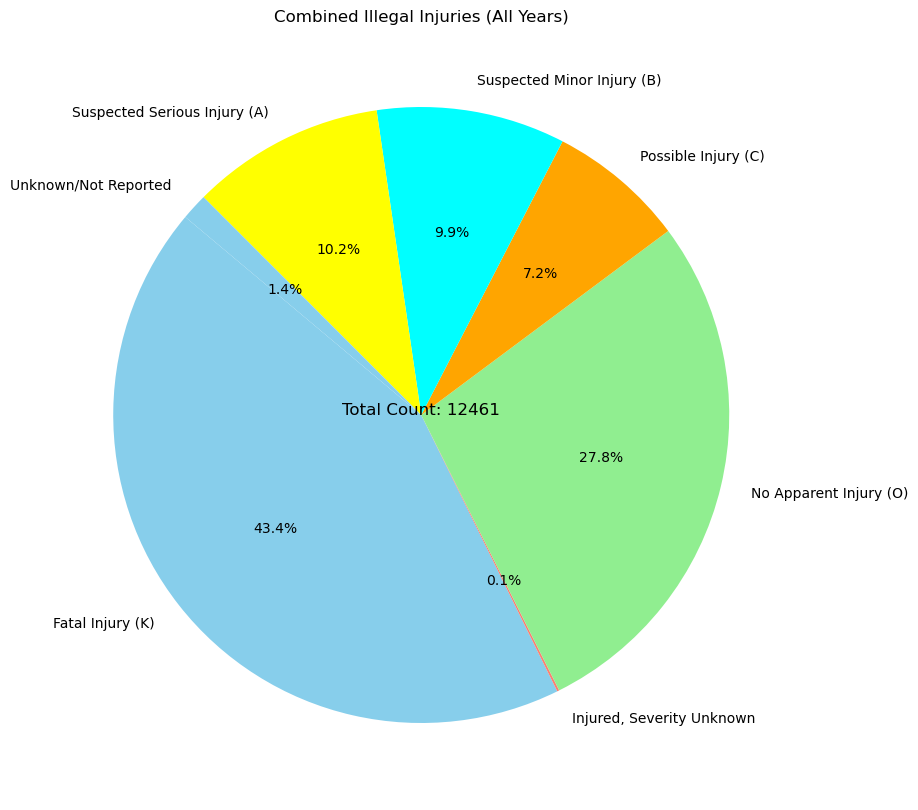

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Concatenate the DataFrames for all years
illegal_combined_df = pd.concat([illegal_2019_df, illegal_2020_df, illegal_2021_df], ignore_index=True)

# Calculate the total counts for each injury type
illegal_injury_chart_combined = illegal_combined_df.groupby("Injury Type")["Count"].sum()

# Create the pie chart
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
wedges, _, autotexts = plt.pie(illegal_injury_chart_combined, labels=illegal_injury_chart_combined.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
total_count_combined = illegal_injury_chart_combined.sum()
plt.text(0, 0, f'Total Count: {total_count_combined}', color='black', fontsize=12, ha='center')
plt.title('Combined Illegal Injuries (All Years)')  # Set the title of the pie chart

plt.show()

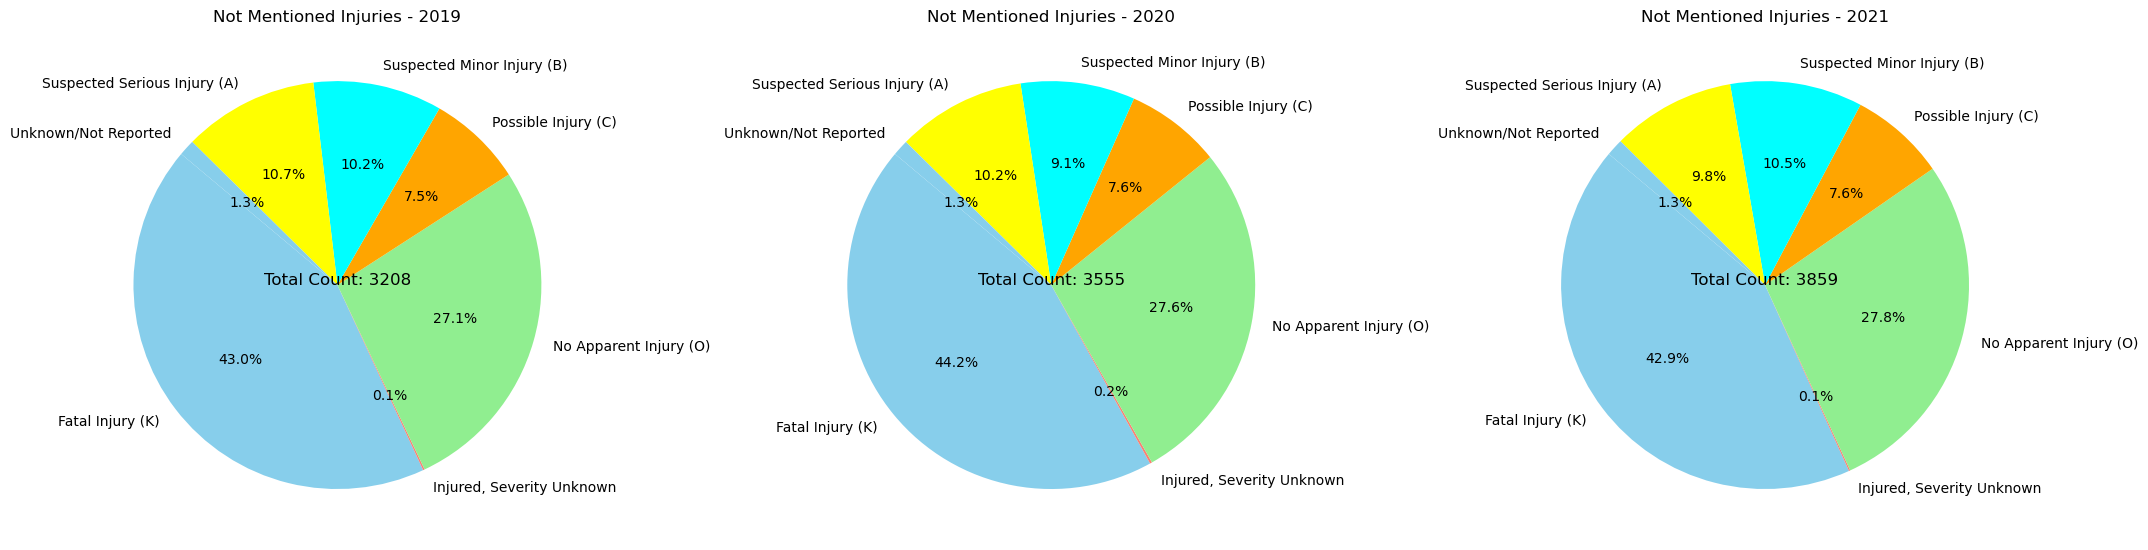

In [21]:
# Visualize data
plt.figure(figsize=(25, 8))  # Increase the width of the figure

# Not Mentioned Pie Charts
years = [2019, 2020, 2021]
for i, not_mentioned_df in enumerate([not_mentioned_2019_df, not_mentioned_2020_df, not_mentioned_2021_df]):
    plt.subplot(1, 3, i+1)  # Adjust subplot indexing
    not_mentioned_injury_chart = not_mentioned_df.groupby("Injury Type")["Count"].sum()
    wedges, _, autotexts = plt.pie(not_mentioned_injury_chart, labels=not_mentioned_injury_chart.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
    total_count = not_mentioned_injury_chart.sum()
    plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
    plt.title(f'Not Mentioned Injuries - {years[i]}')  # Use years list

    plt.subplots_adjust(wspace=0.4)  # Add space between subplots

plt.show()

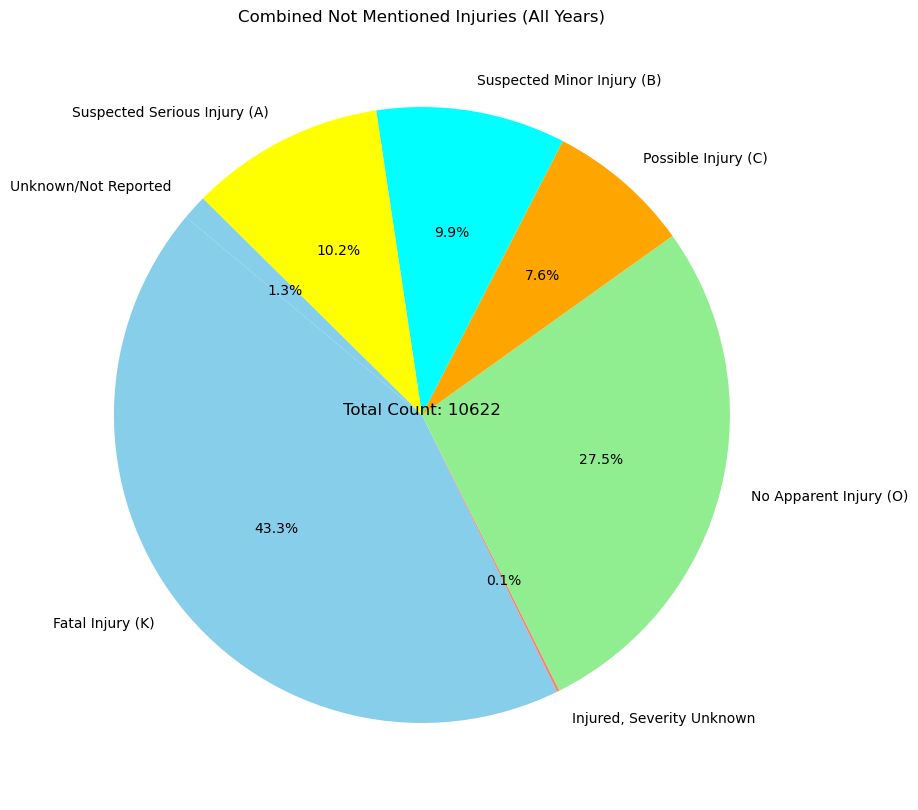

In [26]:
# Concatenate the DataFrames for all years
not_mentioned_combined_df = pd.concat([not_mentioned_2019_df, not_mentioned_2020_df, not_mentioned_2021_df], ignore_index=True)

# Calculate the total counts for each injury type
not_mentioned_injury_chart_combined = not_mentioned_combined_df.groupby("Injury Type")["Count"].sum()

# Create the pie chart
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
wedges, _, autotexts = plt.pie(not_mentioned_injury_chart_combined, labels=not_mentioned_injury_chart_combined.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
total_count_combined = not_mentioned_injury_chart_combined.sum()
plt.text(0, 0, f'Total Count: {total_count_combined}', color='black', fontsize=12, ha='center')
plt.title('Combined Not Mentioned Injuries (All Years)')  # Set the title of the pie chart

plt.show()

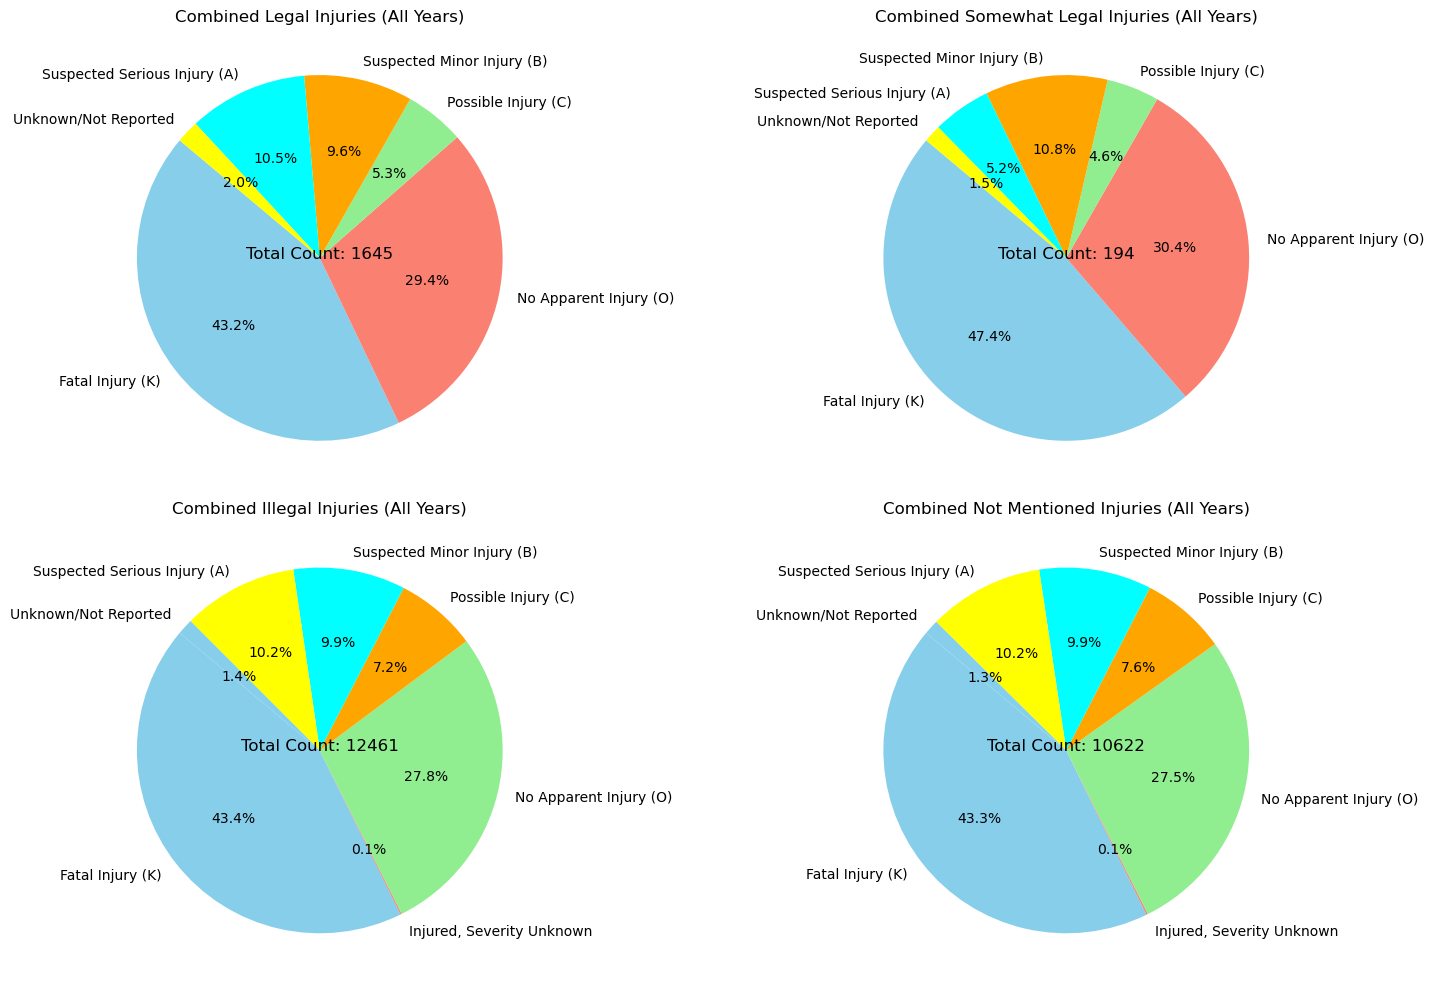

In [34]:
# Concatenate the DataFrames for all years
legal_combined_df = pd.concat([legal_2019_df, legal_2020_df, legal_2021_df], ignore_index=True)
somewhat_legal_combined_df = pd.concat([somewhat_legal_2019_df, somewhat_legal_2020_df, somewhat_legal_2021_df], ignore_index=True)
illegal_combined_df = pd.concat([illegal_2019_df, illegal_2020_df, illegal_2021_df], ignore_index=True)
not_mentioned_combined_df = pd.concat([not_mentioned_2019_df, not_mentioned_2020_df, not_mentioned_2021_df], ignore_index=True)

# Calculate the total counts for each injury type for all combined DataFrames
legal_injury_chart_combined = legal_combined_df.groupby("Injury Type")["Count"].sum()
somewhat_legal_injury_chart_combined = somewhat_legal_combined_df.groupby("Injury Type")["Count"].sum()
illegal_injury_chart_combined = illegal_combined_df.groupby("Injury Type")["Count"].sum()
not_mentioned_injury_chart_combined = not_mentioned_combined_df.groupby("Injury Type")["Count"].sum()

# Create subplots for all pie charts
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Pie chart for Legal Injuries
wedges, _, autotexts = axs[0, 0].pie(legal_injury_chart_combined, labels=legal_injury_chart_combined.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
total_count_combined = legal_injury_chart_combined.sum()
axs[0, 0].text(0, 0, f'Total Count: {total_count_combined}', color='black', fontsize=12, ha='center')
axs[0, 0].set_title('Combined Legal Injuries (All Years)')

# Pie chart for Somewhat Legal Injuries
wedges, _, autotexts = axs[0, 1].pie(somewhat_legal_injury_chart_combined, labels=somewhat_legal_injury_chart_combined.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
total_count_combined = somewhat_legal_injury_chart_combined.sum()
axs[0, 1].text(0, 0, f'Total Count: {total_count_combined}', color='black', fontsize=12, ha='center')
axs[0, 1].set_title('Combined Somewhat Legal Injuries (All Years)')

# Pie chart for Illegal Injuries
wedges, _, autotexts = axs[1, 0].pie(illegal_injury_chart_combined, labels=illegal_injury_chart_combined.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
total_count_combined = illegal_injury_chart_combined.sum()
axs[1, 0].text(0, 0, f'Total Count: {total_count_combined}', color='black', fontsize=12, ha='center')
axs[1, 0].set_title('Combined Illegal Injuries (All Years)')

# Pie chart for Not Mentioned Injuries
wedges, _, autotexts = axs[1, 1].pie(not_mentioned_injury_chart_combined, labels=not_mentioned_injury_chart_combined.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'aqua', 'yellow'])
total_count_combined = not_mentioned_injury_chart_combined.sum()
axs[1, 1].text(0, 0, f'Total Count: {total_count_combined}', color='black', fontsize=12, ha='center')
axs[1, 1].set_title('Combined Not Mentioned Injuries (All Years)')

plt.tight_layout()
plt.show()

Legal - Mean: 274.1666666666667, Median: 165.5, Standard Deviation: 241.99064490641413
Somewhat Legal - Mean: 32.333333333333336, Median: 15.5, Standard Deviation: 32.41227476675396
Illegal - Mean: 1780.142857142857, Median: 1234.0, Standard Deviation: 1813.585117823764
Not Mentioned - Mean: 1517.4285714285713, Median: 1055.0, Standard Deviation: 1538.676598076863

ANOVA Test:
F-statistic: 2.7291358426394097
P-value: 0.06842706567764102


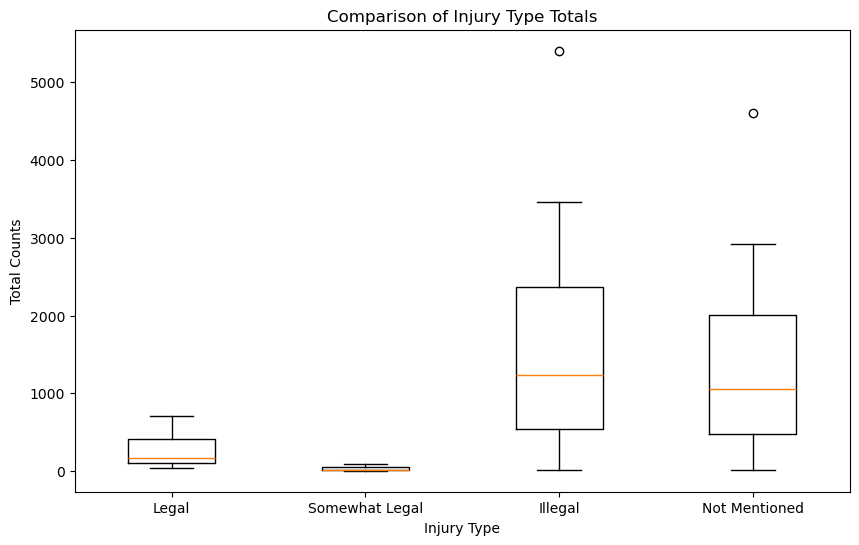

In [41]:
# Calculate summary statistics
totals = {
    "Legal": legal_injury_chart_combined.values,
    "Somewhat Legal": somewhat_legal_injury_chart_combined.values,
    "Illegal": illegal_injury_chart_combined.values,
    "Not Mentioned": not_mentioned_injury_chart_combined.values
}

for label, data in totals.items():
    mean = np.mean(data)
    median = np.median(data)
    std_dev = np.std(data)
    print(f"{label} - Mean: {mean}, Median: {median}, Standard Deviation: {std_dev}")

# Conduct hypothesis test (e.g., ANOVA)
f_statistic, p_value = st.f_oneway(
    legal_injury_chart_combined.values,
    somewhat_legal_injury_chart_combined.values,
    illegal_injury_chart_combined.values,
    not_mentioned_injury_chart_combined.values
)

print("\nANOVA Test:")
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Visualize the data (e.g., box plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(totals.values(), labels=totals.keys())
plt.title("Comparison of Injury Type Totals")
plt.xlabel("Injury Type")
plt.ylabel("Total Counts")
plt.show()